# 1. Import Libraries and Load Files

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load business file
df_b = pd.read_csv('../datasets/business1.csv')

In [3]:
# Load check_in file
df_c = pd.read_parquet("../datasets/parquet_file/check_in.parquet")

In [4]:
# Load review file
df_r = pd.read_parquet("../datasets/parquet_file/review_filtered.parquet")

In [5]:
# Load user file
df_u = pd.read_parquet("../datasets/parquet_file/user.parquet")

# 2. Define Variables for Loyalty Score

### (1) Regular Customer Score

In [6]:
# -------------------------
# 1. Calculate unique and repeat user ratios
# -------------------------
total_reviews = df_r.groupby("business_id")["review_id"].count()
unique_users = df_r.groupby("business_id")["user_id"].nunique()

regular = pd.DataFrame({
    "total_reviews": total_reviews,
    "unique_users": unique_users
})

# Ratio of unique users to total reviews
regular["unique_user_ratio"] = (
    regular["unique_users"] / regular["total_reviews"]
)

# Ratio of repeat users (1 - unique user ratio)
regular["repeat_user_ratio"] = 1 - regular["unique_user_ratio"]



In [7]:
# -------------------------
# 2. Calculate average star rating left by repeat users
# -------------------------

# Count how many reviews each user left for each business
user_review_counts = (
    df_r.groupby(["business_id", "user_id"])["review_id"]
        .count()
        .reset_index(name="review_count")
)

# Keep only users who left at least 2 reviews for the same business
repeat_users = user_review_counts[
    user_review_counts["review_count"] >= 2
][["business_id", "user_id"]]

# Join back to get only repeat-user reviews
repeat_reviews = df_r.merge(repeat_users, on=["business_id", "user_id"], how="inner")

# Average rating given by repeat users, per business
repeat_user_avg_stars = (
    repeat_reviews.groupby("business_id")["stars"]
        .mean()
        .reset_index(name="repeat_user_avg_stars")
)

# Merge into business table
regular = regular.merge(repeat_user_avg_stars, on="business_id", how="left")


In [8]:
regular

,business_id,total_reviews,unique_users,unique_user_ratio,repeat_user_ratio,repeat_user_avg_stars
0,--8IbOsAAxjKRoYsBFL-PA,27,27,1.000000,0.000000,NaN
1,--ZVrH2X2QXBFdCilbirsw,36,32,0.888889,0.111111,5.0
2,-09Oc2D14vRnmirPh0vlXw,77,76,0.987013,0.012987,2.0
3,-0EdehHjIQc0DtYU8QcAig,36,35,0.972222,0.027778,1.0
4,-0G_6-KFGpCpxTUlVXCMYQ,154,148,0.961039,0.038961,3.5
...,...,...,...,...,...,...
19529,zzHtFjfM7NvuVM1HTsCLGA,35,35,1.000000,0.000000,NaN
19530,zzbZtgPYZS8sTIWQH6DwEw,87,86,0.988506,0.011494,2.5
19531,zzfj1-iPfw0cwnOjY0yUgA,25,24,0.960000,0.040000,5.0
19532,zzjFdJwXuxBOGe9JeY_EMw,48,47,0.979167,0.020833,5.0


In [9]:
# -------------------------
# 3. Calculate final Regular Customer Score
# -------------------------

# Fill missing values with defaults
regular["repeat_user_ratio"] = regular["repeat_user_ratio"].fillna(0)
regular["repeat_user_avg_stars"] = regular["repeat_user_avg_stars"].fillna(3)

# Base score
base_score = 0.5

# Score 1: repeat user ratio scaled to a 0–30 point range
score_ratio = regular["repeat_user_ratio"] * 0.3

# Score 2: adjust ±10 points based on deviation from rating 3.0
score_stars = (regular["repeat_user_avg_stars"] - 3) * 0.1

# Final regular customer score
regular["regular_customer_score"] = base_score + score_ratio + score_stars

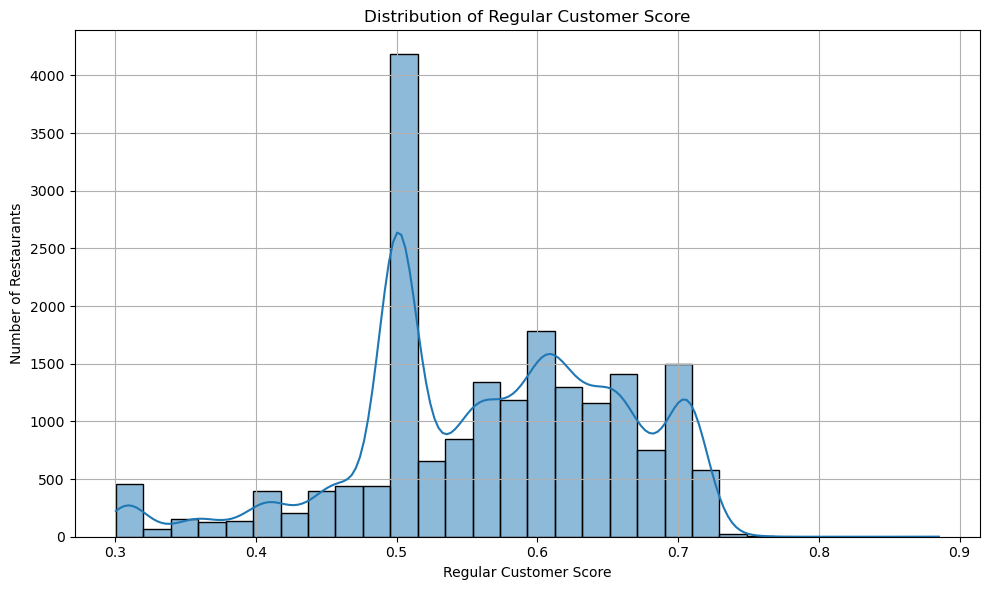

In [10]:
# -------------------------
# 4. Visualize the distribution of Regular Customer Score
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(regular["regular_customer_score"], bins=30, kde=True)

plt.title("Distribution of Regular Customer Score")
plt.xlabel("Regular Customer Score")
plt.ylabel("Number of Restaurants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# ------------------------------------
# 5. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    regular[['business_id', 'regular_customer_score']],
    on='business_id',
    how='left'
)

### (2) Check-in Count

In [12]:
# -------------------------
# 1. Count total check-ins per business
# -------------------------
checkin = df_b[['business_id']].merge(df_c, on="business_id", how="left")

# Convert the check-in date string into a list of timestamps
checkin["checkin_list"] = checkin["date"].apply(
    lambda x: str(x).split(",") if pd.notnull(x) else []
)

# Count the number of check-ins for each business
checkin["checkin_count"] = checkin["checkin_list"].apply(len)

# Replace missing values (businesses without check-ins)
checkin["checkin_count"] = checkin["checkin_count"].fillna(0).astype(int)

In [13]:
# -------------------------
# 2. Normalize Check-in Count
# -------------------------

# Apply log transformation to reduce skewness
checkin["checkin_count_log"] = np.log1p(checkin["checkin_count"])

# Min–Max scaling
scaler = MinMaxScaler()
checkin["checkin_count_norm"] = scaler.fit_transform(checkin[["checkin_count_log"]])


In [14]:
checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19534 entries, 0 to 19533
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   business_id         19534 non-null  object 
 1   date                19509 non-null  object 
 2   checkin_list        19534 non-null  object 
 3   checkin_count       19534 non-null  int64  
 4   checkin_count_log   19534 non-null  float64
 5   checkin_count_norm  19534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 915.8+ KB


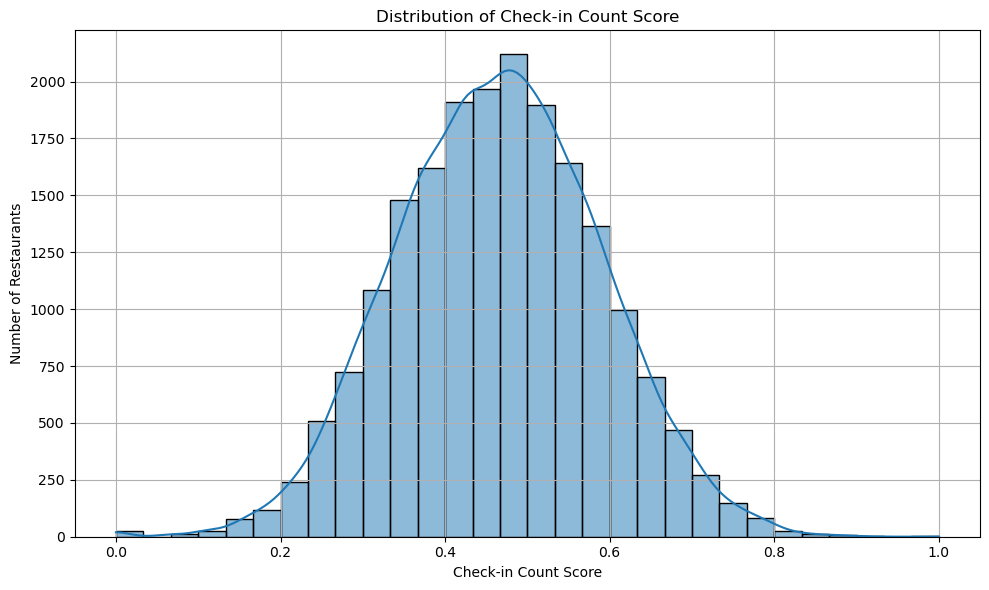

In [15]:
# -------------------------
# 3. Check the distribution of Check-in Count
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(checkin["checkin_count_norm"], bins=30, kde=True)

plt.title('Distribution of Check-in Count Score')
plt.xlabel('Check-in Count Score')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# ------------------------------------
# 4. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    checkin[['business_id', 'checkin_count_norm']],
    on='business_id',
    how='left'
)

### (3) Check-in interval

In [17]:
# -------------------------
# 1. Function to calculate the average check-in interval (in days)
# -------------------------
def calc_checkin_interval(date_str):
    """Calculate the average interval between check-ins (in days) from a comma-separated string"""
    if pd.isna(date_str):  # Handle missing values
        return np.nan
    
    # Split the string by commas and convert each part into a datetime object
    dates = [pd.to_datetime(d.strip(), format='%Y-%m-%d %H:%M:%S', errors='coerce')
             for d in date_str.split(',')]
    
    # Remove invalid (NaT) values
    dates = [d for d in dates if pd.notnull(d)]
    if len(dates) <= 1:  # Need at least two dates to calculate interval
        return np.nan
    
    # Sort the dates and compute time differences
    dates = sorted(dates)
    diffs = np.diff(dates)  # returns an array of timedelta64[ns]
    
    # Fix: use total_seconds() to convert Timedelta to days
    avg_days = np.mean([diff.total_seconds() / (60 * 60 * 24) for diff in diffs])
    return avg_days

# Apply the function to the 'date' column
checkin['checkin_interval'] = checkin['date'].apply(calc_checkin_interval)

# Fill missing values (for businesses without check-in records)
checkin['checkin_interval'] = checkin['checkin_interval'].fillna(0).astype(int)

# Check the results
checkin[['business_id', 'checkin_count', 'checkin_interval']].head()

,business_id,checkin_count,checkin_interval
0,MTSW4McQd7CbVtyjqoe9mw,335,12
1,il_Ro8jwPlHresjw9EGmBg,54,75
2,0bPLkL0QhhPO5kt1_EXmNQ,264,11
3,MUTTqe8uqyMdBl186RmNeA,172,8
4,ROeacJQwBeh05Rqg7F6TCg,221,13


In [18]:
# -------------------------
# 2. Normalize Check-in Interval
# -------------------------
# Log transform 
checkin['checkin_interval_log'] = np.log1p(checkin['checkin_interval'])

# Min-Max normalization
scaler = MinMaxScaler()
checkin['checkin_interval_norm'] = scaler.fit_transform(checkin[['checkin_interval_log']])

# Invert the score so that lower intervals yield higher scores
checkin['checkin_interval_norm'] = (1 - checkin['checkin_interval_norm'])


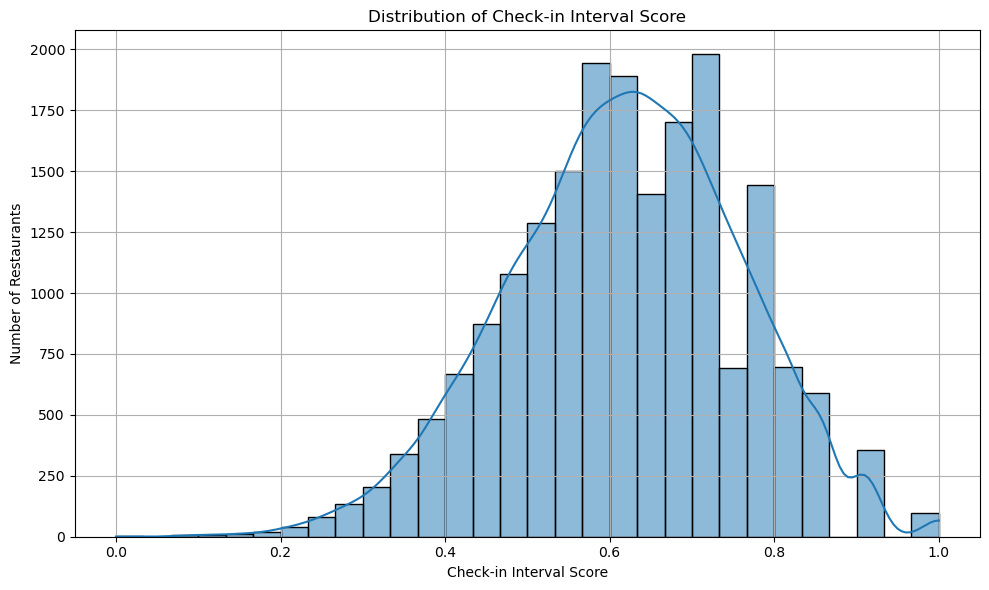

In [19]:
# -------------------------
# 3. Check the distribution of Check-in Interval
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(checkin['checkin_interval_norm'], bins=30, kde=True)

plt.title('Distribution of Check-in Interval Score')
plt.xlabel('Check-in Interval Score')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# ------------------------------------
# 4. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    checkin[['business_id', 'checkin_interval_norm']],
    on='business_id',
    how='left'
)

# 3. Calculate Final Loyalty Score

In [21]:
# Calculate final loyalty score
df_b['loyalty_score'] = (
    50 * df_b['regular_customer_score'] +
    20 * df_b['checkin_count_norm'] +
    30 * df_b['checkin_interval_norm']
)

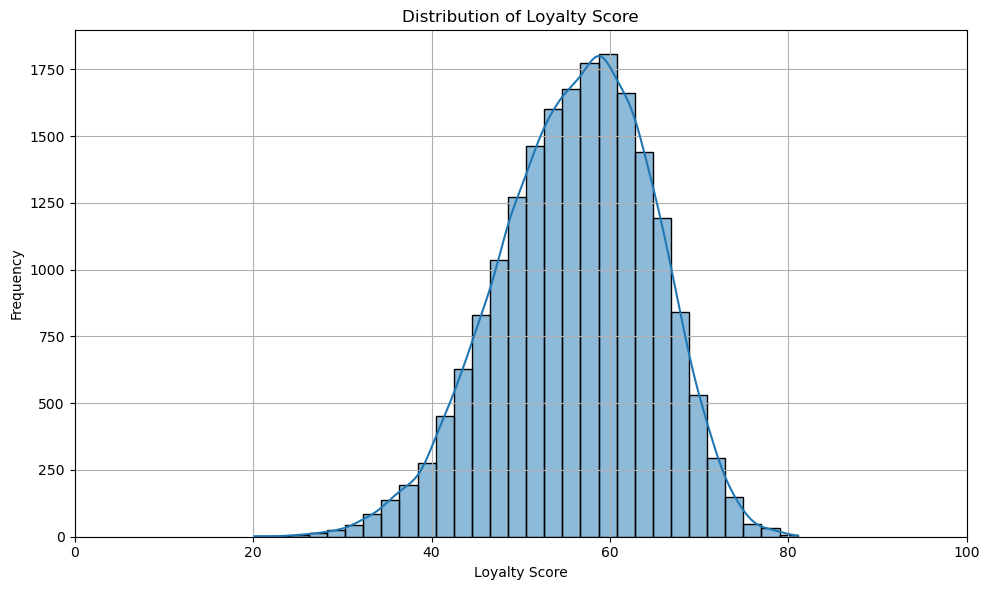

In [22]:
# Check distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_b['loyalty_score'], bins=30, kde=True)

plt.title('Distribution of Loyalty Score')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Save the final dataset as a CSV file
df_b.drop(columns=['regular_customer_score', 'checkin_count_norm', 'checkin_interval_norm'], inplace=True)
df_b.to_csv('../datasets/business2.csv', index=False)